<a href="https://colab.research.google.com/github/tumibytes/cis9650-project03/blob/main/term_project_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Job Listings

### Authors: Elise Tumibay, Dylan Lee, Creed Berges, Dianny Nunez
### Date : December 8th, 2025

## Executive Summary

The dataset used in this project consists of thousands of job postings collected from public sources and stored in a Google Cloud bucket. These postings span multiple global companies across finance, insurance, fintech, consulting, and technology. Each posting contains structured information such as job title, salaries, company name, location, and posted date, as well as additional metadata like skill requirements, responsibilities, departments, or industry tags.

Within the 171 JSON files included in this project, we can explore key insights such as the demand for specific skills, opportunities for different work arrangements, geographical demand, and other labor market patterns. Since the pandemic, a notable portion of job postings reflect remote or hybrid work options, highlighting how work culture has shifted in the post-COVID era.

Analyzing this dataset provides valuable insight, that help us understand current workforce trends, skill demands, and hiring patterns across industries worldwide.

## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Model Planning
8. Model Building / Analysis
9. Discussion & Interpretation
10. Conclusion
11. References
12. Appendix

## Introduction

## Problem Statement / Research Question
Within the 171 json files of job listings for this project, the demand for certain skills, opportunities for different work arrangements, geographical demand, and other metrics can be analyzed. Since the pandemic, there is likely a significant amount of job postings for remote or hybrid work, given the transition of work culture in a post-COVID society.

## Data Description
  The data in Project 03 consists of 171 json files. Each file contains a set of job listings with a title, company, description, summary, salary, work arrangement, and other information relevant to job applicants.

## Setup and Environment

In [1]:
!pip install google-cloud-storage

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import json
import os
from google.cloud import storage
from io import BytesIO

## Data Loading

### Functions

In [3]:
from google.cloud import storage

def list_public_bucket(bucket_name, course, project):
    prefix = f"{course}/Project {project}/"

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blobs = client.list_blobs(bucket, prefix=prefix)
    print(f"Listing files in public bucket '{bucket_name}' under '{prefix}':")
    filenames = []
    for blob in blobs:
        print(blob.name)
        filenames.append(blob.name)

    return filenames

In [4]:
from google.cloud import storage
import pandas as pd
from io import BytesIO
import os
import json

def gcs_file_to_dataframe(bucket_name: str, blob_path: str):

    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Detect file extension
    _, ext = os.path.splitext(blob_path.lower())

    if ext == ".csv":
        df = pd.read_csv(BytesIO(data))

    elif ext in [".xls", ".xlsx"]:
        df = pd.read_excel(BytesIO(data))

    elif ext == ".parquet":
        df = pd.read_parquet(BytesIO(data))

    elif ext == ".json":
        # Convert bytes → Python object
        text = data.decode("utf-8")
        json_obj = json.loads(text)

        # If JSON is a list → NORMAL DataFrame
        if isinstance(json_obj, list):
            df = pd.DataFrame(json_obj)

        # If JSON is a dict → flatten into rows
        elif isinstance(json_obj, dict):
            df = pd.json_normalize(json_obj)

        else:
            raise ValueError("Unsupported JSON structure")

    else:
        raise ValueError(f"Unsupported file type: {ext}")

    return df

In [5]:
# Example
BUCKET_NAME = "msba-online-data"
PROJECT_NUMBER = "03"
COURSE = "CIS9650"
job_listings = list_public_bucket(BUCKET_NAME,COURSE,PROJECT_NUMBER)

Listing files in public bucket 'msba-online-data' under 'CIS9650/Project 03/':
CIS9650/Project 03/
CIS9650/Project 03/page_1.json
CIS9650/Project 03/page_10.json
CIS9650/Project 03/page_100.json
CIS9650/Project 03/page_101.json
CIS9650/Project 03/page_102.json
CIS9650/Project 03/page_103.json
CIS9650/Project 03/page_104.json
CIS9650/Project 03/page_105.json
CIS9650/Project 03/page_106.json
CIS9650/Project 03/page_107.json
CIS9650/Project 03/page_108.json
CIS9650/Project 03/page_109.json
CIS9650/Project 03/page_11.json
CIS9650/Project 03/page_110.json
CIS9650/Project 03/page_111.json
CIS9650/Project 03/page_112.json
CIS9650/Project 03/page_113.json
CIS9650/Project 03/page_114.json
CIS9650/Project 03/page_115.json
CIS9650/Project 03/page_116.json
CIS9650/Project 03/page_117.json
CIS9650/Project 03/page_118.json
CIS9650/Project 03/page_119.json
CIS9650/Project 03/page_12.json
CIS9650/Project 03/page_120.json
CIS9650/Project 03/page_121.json
CIS9650/Project 03/page_122.json
CIS9650/Project

In [6]:
appended_df = []

# for each file, add df to list
for element in job_listings[1:]:
    df = gcs_file_to_dataframe(BUCKET_NAME,  element)
    appended_df.append(df)
    # print(df.head())

In [7]:
df = pd.concat(appended_df, ignore_index=True)
# concat list to df

df_expanded = df.explode("data", ignore_index=True)

# 2. Convert the dict into columns
detail_cols = df_expanded["data"].apply(pd.Series)

# 3. Merge back and drop the dict column
df_flat = pd.concat([df_expanded.drop(columns=["data"]), detail_cols], axis=1)

df_flat

,meta.currentPage,meta.pageSize,meta.pageCount,meta.totalResults,meta.includeRemote,meta.sortBy,meta.facetQueryResults,meta.searchedLocation.countryCode2,meta.searchedLocation.radiusUnit,meta.searchedLocation.radius,...,locationId,cityId,countryId,language,minSalary,maxSalary,salaryCurrency,jobPaymentType,fullCompanyName,workArrangementType
0,1,100,343,34212,False,UNSORTED,[],US,km,100,...,4843564,4843564,6252001,EN,0,0,USD,PAID,Axa Investment Managers Paris,NaN
1,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5128581,5128581,6252001,EN,83000,137000,USD,PAID,Deutsche Bank US,Hybrid
2,1,100,343,34212,False,UNSORTED,[],US,km,100,...,4459467,4459467,6252001,EN,100000,142250,USD,PAID,Deutsche Bank US,Hybrid
3,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5045360,5045360,6252001,EN,84000,127000,USD,PAID,QBE Insurance (Europe) Limited,Remote
4,1,100,343,34212,False,UNSORTED,[],US,km,100,...,5275020,5275020,6252001,EN,100000,150000,USD,PAID,QBE Insurance (Europe) Limited,Remote
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17095,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5262838,5262838,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17096,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5391959,5391959,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17097,99,100,343,34219,False,UNSORTED,[],US,km,100,...,5746545,5746545,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN
17098,99,100,343,34219,False,UNSORTED,[],US,km,100,...,4984247,4984247,6252001,EN,0,0,USD,UNPAID,RADANCY - Fidelity Investments,NaN


## Data Preparation

In [8]:
# here we will clean the data
# check duplicates
# NULL
# get unique values for each column
# outliers

In [9]:
print(df_flat.columns)



Index(['meta.currentPage', 'meta.pageSize', 'meta.pageCount',
       'meta.totalResults', 'meta.includeRemote', 'meta.sortBy',
       'meta.facetQueryResults', 'meta.searchedLocation.countryCode2',
       'meta.searchedLocation.radiusUnit', 'meta.searchedLocation.radius',
       'meta.selectedFilters', 'meta.searchId', 'meta.totalJobCount',
       'meta.topCompanies', '_links.self.href', '_links.next.href',
       '_links.previous.href', '_links.last.href', '_links.first.href', 'id',
       'detailsPageUrl', 'title', 'jobLocation', 'postedDate', 'salary',
       'clientBrandId', 'clientBrandName', 'companyName', 'employmentType',
       'expirationDate', 'expirationDateType', 'isExternalApplication',
       'summary', 'description', 'isHighlighted', 'jobId', 'score',
       'companyLogoUrl', 'jobAdvertLogoUrl', 'positionType', 'sectors',
       'locationId', 'cityId', 'countryId', 'language', 'minSalary',
       'maxSalary', 'salaryCurrency', 'jobPaymentType', 'fullCompanyName',
      

In [10]:
# create lists of unique values for each column
title = df_flat["title"].unique()

# job location is a dictionary, we cannot get "unique" values here
# use apply method to get the unique values for each key
displayName = df_flat["jobLocation"].apply(lambda x: x.get("displayName")).unique()
city = df_flat["jobLocation"].apply(lambda x: x.get("city")).unique()
state = df_flat["jobLocation"].apply(lambda x: x.get("state")).unique()
country = df_flat["jobLocation"].apply(lambda x: x.get("country")).unique()
region = df_flat["jobLocation"].apply(lambda x: x.get("region")).unique()
# add columns to df for these keys
df_flat["displayName"] = df_flat["jobLocation"].apply(lambda x: x.get("displayName"))
df_flat["city"] = df_flat["jobLocation"].apply(lambda x: x.get("city"))
df_flat["state"] = df_flat["jobLocation"].apply(lambda x: x.get("state"))
df_flat["country"] = df_flat["jobLocation"].apply(lambda x: x.get("country"))
df_flat["region"] = df_flat["jobLocation"].apply(lambda x: x.get("region"))

In [11]:
# continue creating lists for unique values in each column
postedDate = df_flat["postedDate"].unique()
salary = df_flat["salary"].unique()
clientBrandId = df_flat["clientBrandId"].unique()
clientBrandName = df_flat["clientBrandName"].unique()
companyName = df_flat["companyName"].unique()
employmentType = df_flat["employmentType"].unique()
expirationDate = df_flat["expirationDate"].unique()
summary = df_flat["summary"].unique()
description = df_flat["description"].unique()
jobId = df_flat["jobId"].unique()
score = df_flat["score"].unique()
companyLogoUrl = df_flat["companyLogoUrl"].unique()
positionType = df_flat["positionType"].unique()


locationId = df_flat["locationId"].unique()
cityId = df_flat["cityId"].unique()
countryId = df_flat["countryId"].unique()
language = df_flat["language"].unique()
minSalary = df_flat["minSalary"].unique()
maxSalary = df_flat["maxSalary"].unique()
salaryCurrency = df_flat["salaryCurrency"].unique()
jobPaymentType = df_flat["jobPaymentType"].unique()
fullCompanyName = df_flat["fullCompanyName"].unique()
workArrangementType = df_flat["workArrangementType"].unique()
# get rid of nan value in unique list
workArrangementType = workArrangementType[pd.notna(workArrangementType)]
print(workArrangementType)



['Hybrid' 'Remote' 'In-Office' 'Flexible' 'Temporarily Remote']


In [12]:
# handle sectors differently
# sectors are lists in json file
sectors = []
for sector_list in df_flat["sectors"]:
    if isinstance(sector_list, list):
        for sector in sector_list:
            sectors.append(sector)
    elif isinstance(sector_list, str): # handle instance where only one sector is listed
        sector.append(sector)
sectors = set(sectors) # convert list of sectors to set for unique values

## Model Planning

In [13]:
# how you plan to get information from the data
# use sum, aggregate, count, etc. to do your analysis

In [14]:
# define function to center labels in bar chart
def add_labels(x, y):
  for i in range(len(x)):
    plt.text(i, y[i], y[i], ha="center") # align text at center

## Model building / Analysis

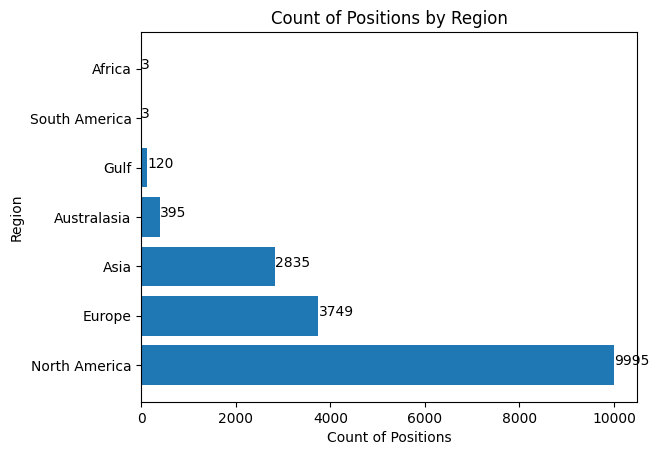

In [15]:
# plot the count of positions by region
fig, ax = plt.subplots()

region_count = df_flat["region"].value_counts()
bar_labels = region_count.index.tolist()
count = region_count.values.tolist()

ax.barh(bar_labels, count)
ax.set_ylabel("Region")
ax.set_xlabel("Count of Positions")
ax.set_title("Count of Positions by Region")

# add values to bar chart for analysis
for index, value in enumerate(region_count):
    plt.text(value, index, str(value))

plt.show()

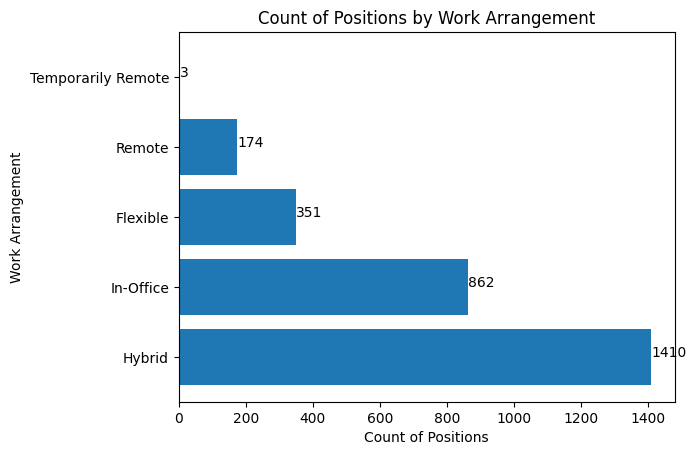

In [16]:
# plot the count of positions by work arrangement type
fig, ax = plt.subplots()

workArr_count = df_flat["workArrangementType"].value_counts()
bar_labels = workArr_count.index.tolist()
count = workArr_count.values.tolist()

ax.barh(bar_labels, count)
ax.set_ylabel("Work Arrangement")
ax.set_xlabel("Count of Positions")
ax.set_title("Count of Positions by Work Arrangement")

# add values to bar chart for analysis
for index, value in enumerate(workArr_count):
    plt.text(value, index, str(value))

plt.show()

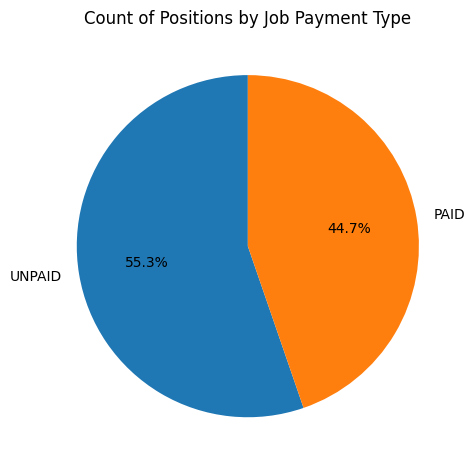

In [17]:
# pie chart the count of positions by job payment type
fig, ax = plt.subplots()

jobPay_count = df_flat["jobPaymentType"].value_counts()
bar_labels = jobPay_count.index.tolist()
count = jobPay_count.values.tolist()

ax.pie(count, labels=bar_labels, autopct="%1.1f%%", startangle=90)
ax.set_title("Count of Positions by Job Payment Type")

plt.tight_layout()
plt.show()

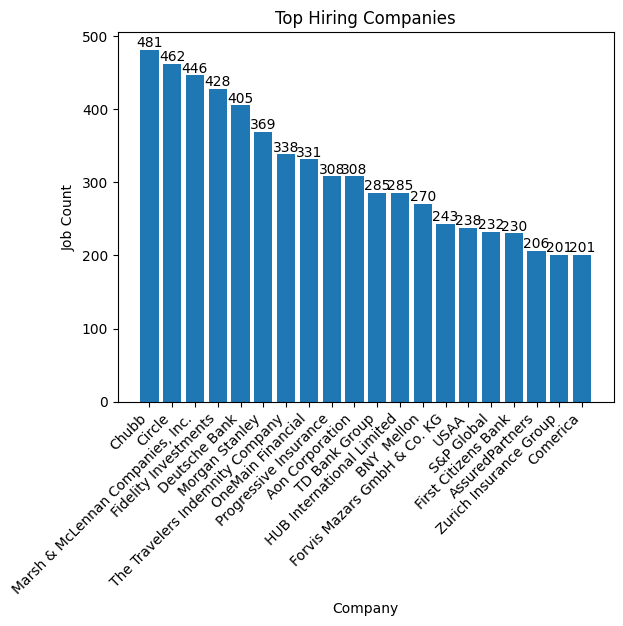

In [18]:
# plot the hiring companies
fig, ax = plt.subplots()

company_count = df_flat["companyName"].value_counts().head(20)
bar_labels = company_count.index.tolist()
count = company_count.values.tolist()

ax.bar(bar_labels, count)
ax.set_xlabel("Company")
ax.set_ylabel("Job Count")
ax.set_title("Top Hiring Companies")

plt.xticks(rotation=45, ha='right')

for index, value in enumerate(count):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

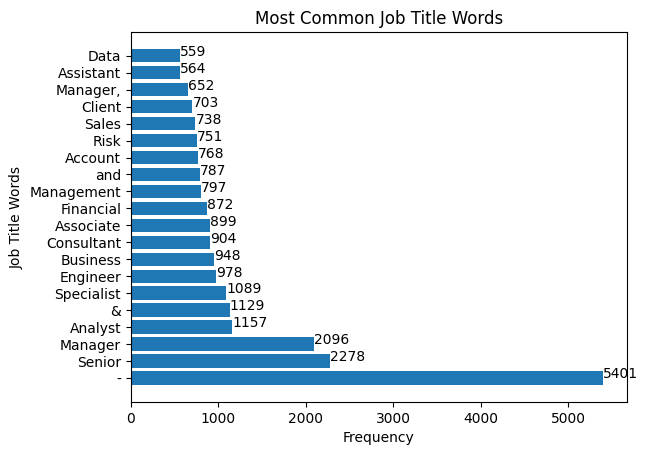

In [19]:
# plot the most common job title words
fig, ax = plt.subplots()

# extract top 20 most frequent words in job_title
job_words = df_flat["title"].str.split(expand=True).stack().value_counts().head(20)
bar_labels = job_words.index.tolist()
count = job_words.values.tolist()

ax.barh(bar_labels, count)
ax.set_ylabel("Job Title Words")
ax.set_xlabel("Frequency")
ax.set_title("Most Common Job Title Words")

for index, value in enumerate(count):
    plt.text(value, index, str(value))

plt.show()

Salary Stats Table (Formatted):
                      minSalary    maxSalary
workArrangementType                         
Remote               $68,168.79  $107,711.55
In-Office            $48,004.06   $74,951.39
Hybrid               $39,144.59   $60,155.99
Flexible             $21,229.39   $37,824.65
Temporarily Remote   $11,666.67   $14,000.00


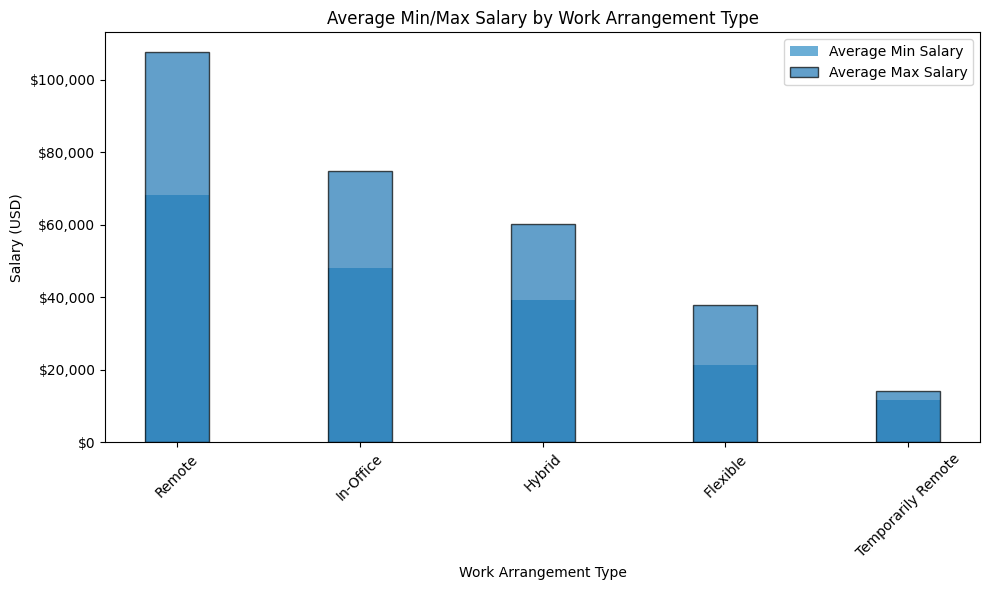

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Convert salary columns to numeric
df_flat["minSalary"] = pd.to_numeric(df_flat["minSalary"], errors="coerce")
df_flat["maxSalary"] = pd.to_numeric(df_flat["maxSalary"], errors="coerce")

# 2. Keep only rows with salary + work arrangement
df_salary = df_flat[
    df_flat["minSalary"].notna() &
    df_flat["maxSalary"].notna() &
    df_flat["workArrangementType"].notna()
]

# 3. Group and compute average salaries (numeric)
numeric_stats = (
    df_salary.groupby("workArrangementType")[["minSalary", "maxSalary"]]
             .mean()
             .sort_values("maxSalary", ascending=False)
)

# Save numeric values for plotting
min_vals = numeric_stats["minSalary"]
max_vals = numeric_stats["maxSalary"]

# Create a formatted copy for display
salary_stats = numeric_stats.copy()
salary_stats["minSalary"] = salary_stats["minSalary"].apply(lambda x: f"${x:,.2f}")
salary_stats["maxSalary"] = salary_stats["maxSalary"].apply(lambda x: f"${x:,.2f}")

print("Salary Stats Table (Formatted):")
print(salary_stats)

# 4. Plot
plt.figure(figsize=(10, 6))

x = numeric_stats.index

plt.bar(x, min_vals, width=0.35, label="Average Min Salary", color="#6baed6")
plt.bar(x, max_vals, width=0.35, label="Average Max Salary", alpha=0.7, edgecolor="black")

plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, pos: f"${x:,.0f}")
)

plt.title("Average Min/Max Salary by Work Arrangement Type")
plt.ylabel("Salary (USD)")
plt.xlabel("Work Arrangement Type")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Discussion and Results

- insights: what did you find in your data? analyze demand for skills, sectors, etc.
- maybe we can use matplotlib to analyze data
- you can explain where you're stuck and where there's room for further analysis
- we can analyze which professions have high demand
- propose to use a ML clustering model to analyze which skills are prominent in the industry

Based on the bar charts in the Model Building/Analysis section, we can see that this source of job listings has the most listings in North America, with Europe and Asia following second.

In the second bar chart, as hypothesized, a majority of jobs are listed as "hybrid." In-office positions followed, with flexible arrangements being more than remote ones. It is important to note that some job listings did not provide information on the work arrangement type. From the 2,800 job listings that did display this information, hybrid arrangements are in higher demand, with remote careers having the least demand in this dataset. It has been half a decade since the pandemic, and it could be argued that companies are looking to have their employees back on site. There is room for further research here.

Across industries, it seems that demand for unpaid positions is slightly higher than that of paid positions.

For future studies, it may be insightful to analyze which skills are high demand for a particular sector using a machine learning approach. This way, the summaries and descriptions for each job listing are of better use for data analysis.

## Conclusion

## References

1. Barber, David. Bayesian Reasoning and Machine Learning. Cambridge University Press, 2012.
2. Aste, Tomaso, Paola Cerchiello, and Roberta Scaramozzino. "Information-Theoretic Causality Detection between Financial and Sentiment Data."Entropy, vol. 24, no. 6, 2022, pp. 1–18. DOI:10.3390/e24060774.
3. Metz, Cade. "Microsoft Puts OpenAI’s Sam Altman in Charge of New Advanced AI Research Team."
The New York Times, 20 Nov. 2023, www.nytimes.com/2023/11/20/technology/openai-microsoft-altman.html
4. **NEED TO FORMAT** used for matplotlib bar chart labels https://www.youtube.com/watch?v=orQWVU4Wbkw
5. **NEED TO FORMAT** pandas notna https://pandas.pydata.org/docs/reference/api/pandas.notna.html
6. **NEED TO FORMAT** used for bar charts https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py
7. **NEED TO FORMAT** also used for bar chart labels (add_labels function)  https://www.geeksforgeeks.org/python/adding-value-labels-on-a-matplotlib-bar-chart/

## Appendix